<a href="https://colab.research.google.com/github/NehaKumari500092077/Image-Processing/blob/main/SLT_CWT_STFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Superlet Transform

In [3]:
pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 6.2 MB/s 


In [6]:
# -- coding: utf-8 --
#
# Time-frequency analysis with superlets
# Based on 'Time-frequency super-resolution with superlets'
# by Moca et al., 2021 Nature Communications
#
# Implementation by Gregor Mönke: github.com/tensionhead
#

import wfdb
import numpy as np
from scipy.signal import fftconvolve


def superlet(
    data_arr,
    samplerate,
    scales,
    order_max,
    order_min=1,
    c_1=3,
    adaptive=False,
):

    """
    Performs Superlet Transform (SLT) according to Moca et al. [1]_
    Both multiplicative SLT and fractional adaptive SLT are available. 
    The former is recommended for a narrow frequency band of interest, 
    whereas the  is better suited for the analysis of a broad range 
    of frequencies.
    A superlet (SL) is a set of Morlet wavelets with increasing number
    of cycles within the Gaussian envelope. Hence the bandwith 
    is constrained more and more with more cycles yielding a sharper
    frequency resolution. Complementary the low cycle numbers will give a
    high time resolution. The SLT then is the geometric mean 
    of the set of individual wavelet transforms, combining both wide
    and narrow-bandwidth wavelets into a super-resolution estimate.
    Parameters
    ----------
    data_arr : nD :class:`numpy.ndarray`
        Uniformly sampled time-series data
        The 1st dimension is interpreted as the time axis
    samplerate : float
        Samplerate of the time-series in Hz
    scales : 1D :class:`numpy.ndarray`
        Set of scales to use in wavelet transform. 
        Note that for the SL Morlet the relationship
        between scale and frequency simply is s(f) = 1/(2*pi*f)
        Need to be ordered high to low for `adaptive=True`
    order_max : int
        Maximal order of the superlet set. Controls the maximum
        number of cycles within a SL together
        with the `c_1` parameter: c_max = c_1 * order_max
    order_min : Minimal order of the superlet set. Controls 
        the minimal number of cycles within a SL together
        with the `c_1` parameter: c_min = c_1 * order_min
        Note that for admissability reasons c_min should be at least 3!
    c_1 : int
        Number of cycles of the base Morlet wavelet. If set to lower
        than 3 increase `order_min` as to never have less than 3 cycles
        in a wavelet!
    adaptive : bool
        Wether to perform multiplicative SLT or fractional adaptive SLT.
        If set to True, the order of the wavelet set will increase
        linearly with the frequencies of interest from `order_min` 
        to `order_max`. If set to False the same SL will be used for
        all frequencies.
    
    Returns
    -------
    gmean_spec : :class:`numpy.ndarray`
        Complex time-frequency representation of the input data. 
        Shape is (len(scales), data_arr.shape[0], data_arr.shape[1]).
    Notes
    -----
    .. [1] Moca, Vasile V., et al. "Time-frequency super-resolution with superlets." 
       Nature communications 12.1 (2021): 1-18.
 
 
    """

    # adaptive SLT
    if adaptive:

        gmean_spec = FASLT(data_arr, samplerate, scales, order_max, order_min, c_1)

    # multiplicative SLT
    else:

        gmean_spec = multiplicativeSLT(
            data_arr, samplerate, scales, order_max, order_min, c_1
        )

    return gmean_spec


def multiplicativeSLT(data_arr, samplerate, scales, order_max, order_min=1, c_1=3):

    dt = 1 / samplerate
    # create the complete multiplicative set spanning
    # order_min - order_max
    cycles = c_1 * np.arange(order_min, order_max + 1)
    order_num = order_max + 1 - order_min # number of different orders
    SL = [MorletSL(c) for c in cycles]

    # lowest order
    gmean_spec = cwtSL(data_arr, SL[0], scales, dt)
    gmean_spec = np.power(gmean_spec, 1 / order_num)

    for wavelet in SL[1:]:

        spec = cwtSL(data_arr, wavelet, scales, dt)
        gmean_spec *= np.power(spec, 1 / order_num)

    return gmean_spec


def FASLT(data_arr, samplerate, scales, order_max, order_min=1, c_1=3):

    """ Fractional adaptive SL transform
    For non-integer orders fractional SLTs are
    calculated in the interval [order, order+1) via:
    
    R(o_f) = R_1 * R_2 * ... * R_i * R_i+1 ** alpha 
    with o_f = o_i + alpha
    """

    dt = 1 / samplerate
    # frequencies of interest
    # from the scales for the SL Morlet
    fois = 1 / (2 * np.pi * scales)
    orders = compute_adaptive_order(fois, order_min, order_max)

    # create the complete superlet set from
    # all enclosed integer orders
    orders_int = np.int32(np.floor(orders))
    cycles = c_1 * np.unique(orders_int)
    SL = [MorletSL(c) for c in cycles]

    # every scale needs a different exponent
    # for the geometric mean
    exponents = 1 / (orders - order_min + 1)

    # which frequencies/scales use the same integer orders SL
    order_jumps = np.where(np.diff(orders_int))[0]
    # each frequency/scale will have its own multiplicative SL
    # which overlap -> higher orders have all the lower orders

    # the fractions
    alphas = orders % orders_int

    # 1st order
    # lowest order is needed for all scales/frequencies
    gmean_spec = cwtSL(data_arr, SL[0], scales, dt)  # 1st order <-> order_min
    # Geometric normalization according to scale dependent order
    gmean_spec = np.power(gmean_spec.T, exponents).T

    # we go to the next scale and order in any case..
    # but for order_max == 1 for which order_jumps is empty
    last_jump = 1

    for i, jump in enumerate(order_jumps):

        # relevant scales for the next order
        scales_o = scales[last_jump:]
        # order + 1 spec
        next_spec = cwtSL(data_arr, SL[i + 1], scales_o, dt)

        # which fractions for the current next_spec
        # in the interval [order, order+1)
        scale_span = slice(last_jump, jump + 1)
        gmean_spec[scale_span, :] *= np.power(
            next_spec[: jump - last_jump + 1].T,
            alphas[scale_span] * exponents[scale_span],
        ).T

        # multiply non-fractional next_spec for
        # all remaining scales/frequencies
        gmean_spec[jump + 1 :] *= np.power(
            next_spec[jump - last_jump + 1 :].T, exponents[jump + 1 :]
        ).T

        # go to the next [order, order+1) interval
        last_jump = jump + 1

    return gmean_spec


class MorletSL:
    def _init_(self, c_i=3, k_sd=5):

        """ The Morlet formulation according to
        Moca et al. shifts the admissability criterion from
        the central frequency to the number of cycles c_i
        within the Gaussian envelope which has a constant 
        standard deviation of k_sd.
        """

        self.c_i = c_i
        self.k_sd = k_sd

    def _call_(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0):

        """
        Complext Morlet wavelet in the SL formulation.
        
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        
        """

        ts = t / s
        # scaled time spread parameter
        # also includes scale normalisation!
        B_c = self.k_sd / (s * self.c_i * (2 * np.pi) ** 1.5)

        output = B_c * np.exp(1j * ts)
        output = np.exp(-0.5 * (self.k_sd * ts / (2 * np.pi * self.c_i)) * 2)

        return output


def fourier_period(scale):

    """
    This is the approximate Morlet fourier period
    as used in the source publication of Moca et al. 2021
    Note that w0 (central frequency) is always 1 in this 
    Morlet formulation, hence the scales are not compatible
    to the standard Wavelet definitions!
    """

    return 2 * np.pi * scale


def scale_from_period(period):

    return period / (2 * np.pi)


def cwtSL(data, wavelet, scales, dt):

    """
    The continuous Wavelet transform specifically
    for Morlets with the Superlet formulation
    of Moca et al. 2021.
    - Morlet support gets adjusted by number of cycles
    - normalisation is with 1/(scale * 4pi)
    - this way the norm of the spectrum (modulus) 
      at the corresponding harmonic frequency is the 
      harmonic signal's amplitude
    Notes
    -----
    
    The time axis is expected to be along the 1st dimension.
    """

    # wavelets can be complex so output is complex
    output = np.zeros((len(scales),) + data.shape, dtype=np.complex64)

    # this checks if really a Superlet Wavelet is being used
    if not isinstance(wavelet, MorletSL):
        raise ValueError("Wavelet is not of MorletSL type!")

    # 1st axis is time
    slices = [None for _ in data.shape]
    slices[0] = slice(None)

    # compute in time
    for ind, scale in enumerate(scales):

        t = _get_superlet_support(scale, dt, wavelet.c_i)
        # sample wavelet and normalise
        norm = dt ** 0.5 / (4 * np.pi)
        wavelet_data = norm * wavelet(t, scale)  # this is an 1d array for sure!
        output[ind, :] = fftconvolve(data, wavelet_data[tuple(slices)], mode="same")

    return output


def _get_superlet_support(scale, dt, cycles):

    """
    Effective support for the convolution is here not only 
    scale but also cycle dependent.
    """

    # number of points needed to capture wavelet
    M = 10 * scale * cycles / dt
    # times to use, centred at zero
    t = np.arange((-M + 1) / 2.0, (M + 1) / 2.0) * dt

    return t


def compute_adaptive_order(freq, order_min, order_max):

    """
    Computes the superlet order for a given frequency of interest 
    for the fractional adaptive SLT (FASLT) according to 
    equation 7 of Moca et al. 2021.
    
    This is a simple linear mapping between the minimal
    and maximal order onto the respective minimal and maximal
    frequencies. 
    Note that `freq` should be ordered low to high.
    """

    f_min, f_max = freq[0], freq[-1]

    assert f_min < f_max

    order = (order_max - order_min) * (freq - f_min) / (f_max - f_min)

    # return np.int32(order_min + np.rint(order))
    return order_min + order


# ---------------------------------------------------------
# Some test data akin to figure 3 of the source publication
# ---------------------------------------------------------


if _name_ == "_main_":

    # to get sth for the eyes ;)
    import matplotlib.pyplot as ppl

    fs = 360  # sampling frequency

    signal, fields = wfdb.rdsamp('/content/100', channels=[0])
    
    # frequencies of interest in Hz
    foi = np.linspace(1, 100, 50)
    scales = scale_from_period(1 / foi)

    spec = superlet(
        signal[:3600],
        samplerate=fs,
        scales=scales,
        order_max=30,
        order_min=1,
        c_1=5,
        adaptive=True,
    )

    # amplitude scalogram
    ampls = np.abs(spec)

    fig, (ax1, ax2) = ppl.subplots(2, 1,
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [1, 3]},
                                   figsize=(5,5))

    ax1.plot(np.arange(signal[:3600].size) / fs*10000, signal[:3600], c='cornflowerblue')
    ax1.set_ylabel('signal (a.u.)')
    #ax1.set_xlabel('time')
    
    extent = [0, len(signal[:3600]) / fs*10000, foi[0], foi[-1]]
    im = ax2.imshow(np.squeeze(ampls), cmap="jet", aspect="auto", extent=extent, origin='lower')
    
    ppl.colorbar(im,ax = ax2, orientation='horizontal',
                 shrink=0.7, pad=0.2, label='amplitude (a.u.)')
    
   # ax2.plot([0, len(signal[:3600]) / fs*10000], [20, 20], "--", c='0.5')
   # ax2.plot([0, len(signal[:3600]) / fs*10000], [40, 40], "--", c='0.5')
   # ax2.plot([0, len(signal[:3600]) / fs*10000], [60, 60], "--", c='0.5')
    
    ax2.set_xlabel("time (s)")    
    ax2.set_ylabel("frequency (Hz)")

    fig.tight_layout()

    
   #   'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean',

NameError: ignored

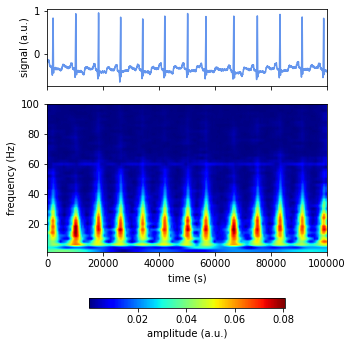

In [13]:
# https://github.com/TransylvanianInstituteOfNeuroscience/Superlets/blob/main/python/superlet.py

# -*- coding: utf-8 -*-
#
# Time-frequency analysis with superlets
# Based on 'Time-frequency super-resolution with superlets'
# by Moca et al., 2021 Nature Communications
#
# Implementation by Gregor Mönke: github.com/tensionhead
#


import numpy as np
from scipy.signal import fftconvolve


def superlet(
    data_arr,
    samplerate,
    scales,
    order_max,
    order_min=1,
    c_1=3,
    adaptive=False,
):

    """
    Performs Superlet Transform (SLT) according to Moca et al. [1]_
    Both multiplicative SLT and fractional adaptive SLT are available. 
    The former is recommended for a narrow frequency band of interest, 
    whereas the  is better suited for the analysis of a broad range 
    of frequencies.
    A superlet (SL) is a set of Morlet wavelets with increasing number
    of cycles within the Gaussian envelope. Hence the bandwith 
    is constrained more and more with more cycles yielding a sharper
    frequency resolution. Complementary the low cycle numbers will give a
    high time resolution. The SLT then is the geometric mean 
    of the set of individual wavelet transforms, combining both wide
    and narrow-bandwidth wavelets into a super-resolution estimate.
    Parameters
    ----------
    data_arr : nD :class:`numpy.ndarray`
        Uniformly sampled time-series data
        The 1st dimension is interpreted as the time axis
    samplerate : float
        Samplerate of the time-series in Hz
    scales : 1D :class:`numpy.ndarray`
        Set of scales to use in wavelet transform. 
        Note that for the SL Morlet the relationship
        between scale and frequency simply is s(f) = 1/(2*pi*f)
        Need to be ordered high to low for `adaptive=True`
    order_max : int
        Maximal order of the superlet set. Controls the maximum
        number of cycles within a SL together
        with the `c_1` parameter: c_max = c_1 * order_max
    order_min : Minimal order of the superlet set. Controls 
        the minimal number of cycles within a SL together
        with the `c_1` parameter: c_min = c_1 * order_min
        Note that for admissability reasons c_min should be at least 3!
    c_1 : int
        Number of cycles of the base Morlet wavelet. If set to lower
        than 3 increase `order_min` as to never have less than 3 cycles
        in a wavelet!
    adaptive : bool
        Wether to perform multiplicative SLT or fractional adaptive SLT.
        If set to True, the order of the wavelet set will increase
        linearly with the frequencies of interest from `order_min` 
        to `order_max`. If set to False the same SL will be used for
        all frequencies.
    
    Returns
    -------
    gmean_spec : :class:`numpy.ndarray`
        Complex time-frequency representation of the input data. 
        Shape is (len(scales), data_arr.shape[0], data_arr.shape[1]).
    Notes
    -----
    .. [1] Moca, Vasile V., et al. "Time-frequency super-resolution with superlets." 
       Nature communications 12.1 (2021): 1-18.
 
 
    """

    # adaptive SLT
    if adaptive:

        gmean_spec = FASLT(data_arr, samplerate, scales, order_max, order_min, c_1)

    # multiplicative SLT
    else:

        gmean_spec = multiplicativeSLT(
            data_arr, samplerate, scales, order_max, order_min, c_1
        )

    return gmean_spec


def multiplicativeSLT(data_arr, samplerate, scales, order_max, order_min=1, c_1=3):

    dt = 1 / samplerate
    # create the complete multiplicative set spanning
    # order_min - order_max
    cycles = c_1 * np.arange(order_min, order_max + 1)
    order_num = order_max + 1 - order_min # number of different orders
    SL = [MorletSL(c) for c in cycles]

    # lowest order
    gmean_spec = cwtSL(data_arr, SL[0], scales, dt)
    gmean_spec = np.power(gmean_spec, 1 / order_num)

    for wavelet in SL[1:]:

        spec = cwtSL(data_arr, wavelet, scales, dt)
        gmean_spec *= np.power(spec, 1 / order_num)

    return gmean_spec


def FASLT(data_arr, samplerate, scales, order_max, order_min=1, c_1=3):

    """ Fractional adaptive SL transform
    For non-integer orders fractional SLTs are
    calculated in the interval [order, order+1) via:
    
    R(o_f) = R_1 * R_2 * ... * R_i * R_i+1 ** alpha 
    with o_f = o_i + alpha
    """

    dt = 1 / samplerate
    # frequencies of interest
    # from the scales for the SL Morlet
    fois = 1 / (2 * np.pi * scales)
    orders = compute_adaptive_order(fois, order_min, order_max)

    # create the complete superlet set from
    # all enclosed integer orders
    orders_int = np.int32(np.floor(orders))
    cycles = c_1 * np.unique(orders_int)
    SL = [MorletSL(c) for c in cycles]

    # every scale needs a different exponent
    # for the geometric mean
    exponents = 1 / (orders - order_min + 1)

    # which frequencies/scales use the same integer orders SL
    order_jumps = np.where(np.diff(orders_int))[0]
    # each frequency/scale will have its own multiplicative SL
    # which overlap -> higher orders have all the lower orders

    # the fractions
    alphas = orders % orders_int

    # 1st order
    # lowest order is needed for all scales/frequencies
    gmean_spec = cwtSL(data_arr, SL[0], scales, dt)  # 1st order <-> order_min
    # Geometric normalization according to scale dependent order
    gmean_spec = np.power(gmean_spec.T, exponents).T

    # we go to the next scale and order in any case..
    # but for order_max == 1 for which order_jumps is empty
    last_jump = 1

    for i, jump in enumerate(order_jumps):

        # relevant scales for the next order
        scales_o = scales[last_jump:]
        # order + 1 spec
        next_spec = cwtSL(data_arr, SL[i + 1], scales_o, dt)

        # which fractions for the current next_spec
        # in the interval [order, order+1)
        scale_span = slice(last_jump, jump + 1)
        gmean_spec[scale_span, :] *= np.power(
            next_spec[: jump - last_jump + 1].T,
            alphas[scale_span] * exponents[scale_span],
        ).T

        # multiply non-fractional next_spec for
        # all remaining scales/frequencies
        gmean_spec[jump + 1 :] *= np.power(
            next_spec[jump - last_jump + 1 :].T, exponents[jump + 1 :]
        ).T

        # go to the next [order, order+1) interval
        last_jump = jump + 1

    return gmean_spec


class MorletSL:
    def __init__(self, c_i=3, k_sd=5):

        """ The Morlet formulation according to
        Moca et al. shifts the admissability criterion from
        the central frequency to the number of cycles c_i
        within the Gaussian envelope which has a constant 
        standard deviation of k_sd.
        """

        self.c_i = c_i
        self.k_sd = k_sd

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0):

        """
        Complext Morlet wavelet in the SL formulation.
        
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        
        """

        ts = t / s
        # scaled time spread parameter
        # also includes scale normalisation!
        B_c = self.k_sd / (s * self.c_i * (2 * np.pi) ** 1.5)

        output = B_c * np.exp(1j * ts)
        output *= np.exp(-0.5 * (self.k_sd * ts / (2 * np.pi * self.c_i)) ** 2)

        return output


def fourier_period(scale):

    """
    This is the approximate Morlet fourier period
    as used in the source publication of Moca et al. 2021
    Note that w0 (central frequency) is always 1 in this 
    Morlet formulation, hence the scales are not compatible
    to the standard Wavelet definitions!
    """

    return 2 * np.pi * scale


def scale_from_period(period):

    return period / (2 * np.pi)


def cwtSL(data, wavelet, scales, dt):

    """
    The continuous Wavelet transform specifically
    for Morlets with the Superlet formulation
    of Moca et al. 2021.
    - Morlet support gets adjusted by number of cycles
    - normalisation is with 1/(scale * 4pi)
    - this way the norm of the spectrum (modulus) 
      at the corresponding harmonic frequency is the 
      harmonic signal's amplitude
    Notes
    -----
    
    The time axis is expected to be along the 1st dimension.
    """

    # wavelets can be complex so output is complex
    output = np.zeros((len(scales),) + data.shape, dtype=np.complex64)

    # this checks if really a Superlet Wavelet is being used
    if not isinstance(wavelet, MorletSL):
        raise ValueError("Wavelet is not of MorletSL type!")

    # 1st axis is time
    slices = [None for _ in data.shape]
    slices[0] = slice(None)

    # compute in time
    for ind, scale in enumerate(scales):

        t = _get_superlet_support(scale, dt, wavelet.c_i)
        # sample wavelet and normalise
        norm = dt ** 0.5 / (4 * np.pi)
        wavelet_data = norm * wavelet(t, scale)  # this is an 1d array for sure!
        output[ind, :] = fftconvolve(data, wavelet_data[tuple(slices)], mode="same")

    return output


def _get_superlet_support(scale, dt, cycles):

    """
    Effective support for the convolution is here not only 
    scale but also cycle dependent.
    """

    # number of points needed to capture wavelet
    M = 10 * scale * cycles / dt
    # times to use, centred at zero
    t = np.arange((-M + 1) / 2.0, (M + 1) / 2.0) * dt

    return t


def compute_adaptive_order(freq, order_min, order_max):

    """
    Computes the superlet order for a given frequency of interest 
    for the fractional adaptive SLT (FASLT) according to 
    equation 7 of Moca et al. 2021.
    
    This is a simple linear mapping between the minimal
    and maximal order onto the respective minimal and maximal
    frequencies. 
    Note that `freq` should be ordered low to high.
    """

    f_min, f_max = freq[0], freq[-1]

    assert f_min < f_max

    order = (order_max - order_min) * (freq - f_min) / (f_max - f_min)

    # return np.int32(order_min + np.rint(order))
    return order_min + order


# ---------------------------------------------------------
# Some test data akin to figure 3 of the source publication
# ---------------------------------------------------------



if __name__ == "__main__":

    # to get sth for the eyes ;)
    import matplotlib.pyplot as ppl

    fs = 360  # sampling frequency
    signal, fields = wfdb.rdsamp('/content/100', channels=[0])
    
    # frequencies of interest in Hz
    foi = np.linspace(1, 100, 50)
    scales = scale_from_period(1 / foi)

    spec = superlet(
        signal[:3600],
        samplerate=fs,
        scales=scales,
        order_max=30,
        order_min=1,
        c_1=5,
        adaptive=True,
    )

    # amplitude scalogram
    fig, (ax1, ax2) = ppl.subplots(2, 1,
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [1, 3]},
                                   figsize=(5,5))

    ax1.plot(np.arange(signal[:3600].size) / fs*10000, signal[:3600], c='cornflowerblue')
    ax1.set_ylabel('signal (a.u.)')
    #ax1.set_xlabel('time')
    
    extent = [0, len(signal[:3600]) / fs*10000, foi[0], foi[-1]]
    im = ax2.imshow(np.squeeze(ampls), cmap="jet", aspect="auto", extent=extent, origin='lower')
    
    ppl.colorbar(im,ax = ax2, orientation='horizontal',
                 shrink=0.7, pad=0.2, label='amplitude (a.u.)')
    
   # ax2.plot([0, len(signal[:3600]) / fs*10000], [20, 20], "--", c='0.5')
   # ax2.plot([0, len(signal[:3600]) / fs*10000], [40, 40], "--", c='0.5')
   # ax2.plot([0, len(signal[:3600]) / fs*10000], [60, 60], "--", c='0.5')
    
    ax2.set_xlabel("time (s)")    
    ax2.set_ylabel("frequency (Hz)")

    fig.tight_layout()

CWT

In [15]:
pip install spkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.2 MB/s 


/usr/local/lib/python3.7/dist-packages/spkit/core/cwt.py:123: RuntimeWarning: divide by zero encountered in true_divide
  Wf = np.sqrt(np.pi / a)* np.exp(-2j * np.pi * f * t0)* np.exp(-np.pi ** 2 *((f - f0) ** 2)/ a)
/usr/local/lib/python3.7/dist-packages/spkit/core/cwt.py:123: RuntimeWarning: invalid value encountered in multiply
  Wf = np.sqrt(np.pi / a)* np.exp(-2j * np.pi * f * t0)* np.exp(-np.pi ** 2 *((f - f0) ** 2)/ a)


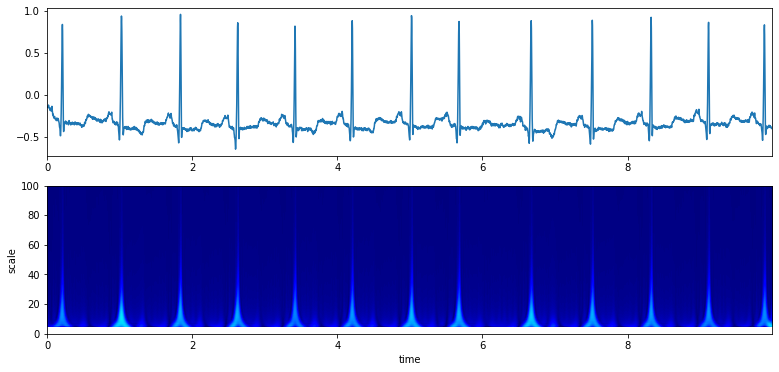

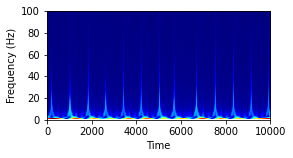

In [16]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np
from matplotlib import ticker as mticker
import numpy as np
import matplotlib.pyplot as plt

import spkit
import spkit as sp

sig, fields = wfdb.rdsamp('/content/100',
                                  channels=[0])
sound_mono1 = sig[1:len(sig),0 ]
t = np.arange(3600)/360

f0 = np.linspace(0,100,100)
#sp.cwt.compare_cwt_example(sound_mono1[:3600],t,fs=360)
XW,S = sp.cwt.ScalogramCWT(sound_mono1[:3600],t,fs=360,wType='Gauss',PlotPSD=True,f0=f0)

fig = plt.figure(figsize=(4,2))
plt.imshow(np.abs(XW),aspect='auto',origin='lower',cmap='jet',interpolation='None',extent =[0, 1000, 0, 100])
fig.gca().set_yticks(range(0, 120, 20))
fig.gca().set_xticks(range(0, 1100, 200))
fig.gca().get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x)*10)))
fig.gca().set_xlabel("Time")
fig.gca().set_ylabel("Frequency (Hz)")
plt.show()

STFT

Text(0, 0.5, 'Frequency (Hz)')

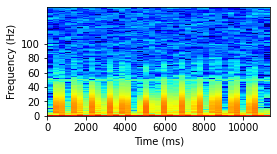

In [17]:
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import wfdb
import numpy as np
from matplotlib import ticker as mticker

sig, fields = wfdb.rdsamp('/content/100',
                                  sampfrom=800,
                                  channels=[0])

sound_mono1 = sig[1:len(sig),0 ]

#https://musicinformationretrieval.com/stft.html
hop_length = 100
n_fft = 300
X = librosa.stft(sound_mono1[:3600], n_fft=n_fft, hop_length=hop_length)#https://librosa.org/doc/main/generated/librosa.stft.html
S = librosa.amplitude_to_db(abs(X),ref=np.max)

fig = plt.figure(figsize=(4, 2))


librosa.display.specshow(S[:3600], sr=325, hop_length=hop_length, x_axis='ms',cmap='jet')
fig.gca().set_yticks(range(0, 120, 20))
fig.gca().set_xticks(range(0, 12, 2))
fig.gca().get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x)*1000)))
fig.gca().set_xlabel("Time (ms)")
fig.gca().set_ylabel("Frequency (Hz)")